In [ ]:
import subprocess
import pydot
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import poisson, norm, chisquare
import time

import numpy as np
import math

Код для замера времени исполнения генерации

In [ ]:
def measure_execution_time(program, num_vertices, density, num_trials):
    total_time = 0
    for _ in range(num_trials):
        start_time = time.time()
        subprocess.run([program, str(num_vertices), str(density)], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        end_time = time.time()
        execution_time = end_time - start_time
        total_time += execution_time
        # print(execution_time)
    average_time = total_time / num_trials
    return average_time

# prod- файл -- файл для замера производительности
subprocess.run(["g++", "-std=c++17", "-O3", "-march=native", "-o", "a", "prufer_prod.cpp"], check=True)
program_name = "a.exe"
num_vertices = 10000
density = 0  # Случайная плотность
num_trials = 10
average_execution_time = measure_execution_time(program_name, num_vertices, density, num_trials)
print(f"Average execution time over {num_trials} trials: {average_execution_time:.6f} seconds")

Average execution time over 10 trials: 2.048807 seconds


**Демонстрация генератора**

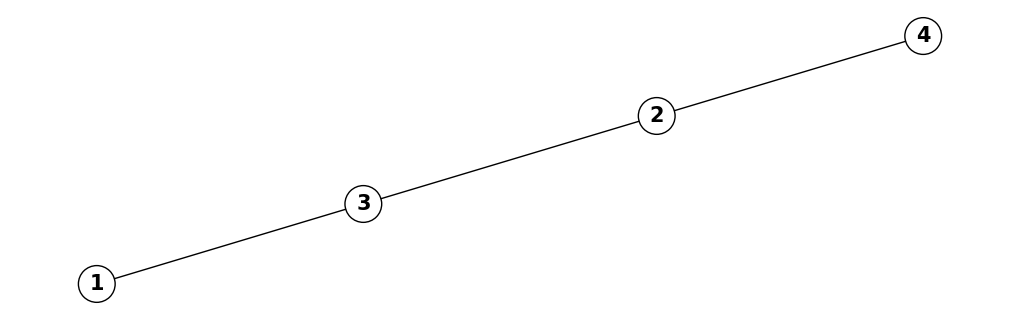

In [32]:
# Компиляция prufer.cpp с помощью g++
#subprocess.run(["g++", "-std=c++17", "-O3", "-march=native", "-o", "a", "prufer.cpp"], check=True)
# Запуск a.exe и ожидание завершения
subprocess.run(["a.exe", "4", "0"], check=True)

# Загружаем граф из файла в формате dot с помощью networkx и pydot
G = nx.nx_pydot.read_dot('graph.dot')

# Рисуем дерево
plt.figure(figsize=(10, 3))
nx.draw(G, 
        with_labels=True, 
        node_size=700,
        node_color="none",
        edgecolors="black",
        font_size=15, 
        font_weight='bold', 
        edge_color='black', 
        font_color='black') 
plt.show()

**Построение гистограммы**

In [34]:
# Функция для чтения рёбер из файла DOT
def read_dot_edges(dot_file):
    edges = []
    with open(dot_file, 'r') as f:
        for line in f:
            if '--' in line:
                parts = line.strip().strip(';').split(' -- ')
                if len(parts) == 2:
                    edges.append(tuple(map(int, parts)))
    return edges

# Функция сбора статистики
def get_sample_4deg(n, trials, density):
    all_degrees = []
    for i in range(trials):
        # Запускаем генерацию графа
        subprocess.run(["a.exe", str(n), str(density)], check=True)
        # Читаем рёбра из файла
        edges = read_dot_edges('graph.dot')
        # Подсчитываем степени вершин
        degree_count = defaultdict(int)  # Сброс перед каждым испытанием
        for u, v in edges:
            degree_count[u] += 1
            degree_count[v] += 1
        # Добавляем степени всех вершин в общий список
        all_degrees.extend(degree_count.values())
    return all_degrees

Использование генератора

In [66]:
# Количество вершин
n = 100
# Плотность
density = 0.1
# Количество испытаний
trials = 10000
# Список для хранения степеней всех вершин во всех испытаниях
all_degrees = get_sample_4deg(n, trials, density)

# Определяем диапазон значений степеней вершин
min_degree = min(all_degrees)
max_degree = max(all_degrees)

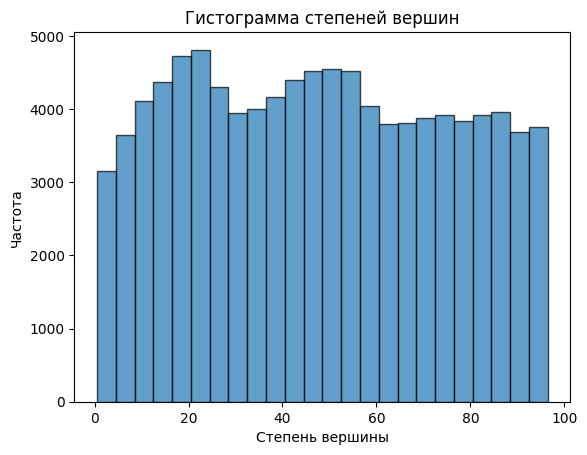

Частоты по бинам: [3158 3643 4108 4376 4723 4812 4303 3942 3995 4162 4394 4524 4544 4519
 4037 3802 3808 3880 3915 3838 3919 3961 3689 3761]
Границы бинов: [ 0.5  4.5  8.5 12.5 16.5 20.5 24.5 28.5 32.5 36.5 40.5 44.5 48.5 52.5
 56.5 60.5 64.5 68.5 72.5 76.5 80.5 84.5 88.5 92.5 96.5]


In [65]:
# Число бинов
num_bins = (n - 1)//4  # Бины от 1 до N-1, то есть, для 4 вершин, бины от 1 до 3
# Определяем границы бинов
bin_edges = np.arange(0.5, n + 0.5, n/(num_bins + 1))

# Строим гистограмму степеней вершин с использованием указанных границ бинов
plt.hist(all_degrees, bins=bin_edges, edgecolor='black', alpha=0.7)
plt.title('Гистограмма степеней вершин')
plt.xlabel('Степень вершины')
plt.ylabel('Частота')

# Показать гистограмму
plt.show()

'''
# Используем логарифмическую оценку для количества бинов
num_bins = n#math.ceil(math.log2(len(all_degrees)) + 1)

# Строим гистограмму степеней вершин
plt.hist(all_degrees, bins=num_bins, edgecolor='black', alpha=0.7)
plt.title('Гистограмма степеней вершин')
plt.xlabel('Степень вершины')
plt.ylabel('Частота')
plt.show()
'''
hist_values, bin_edges = np.histogram(all_degrees, bins=bin_edges)

# Выводим частоты для каждого бина
print("Частоты по бинам:", hist_values)
print("Границы бинов:", bin_edges)

Анализ гистограммы с ипользованием построения в c++

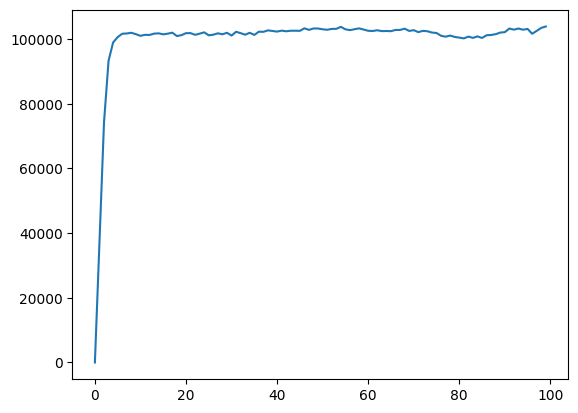

In [82]:
import numpy as np

def read_vector_from_file(filename):
    with open(filename, "rb") as f:
        size = np.fromfile(f, dtype=np.int32, count=1)[0]  # Читаем размер
        vec = np.fromfile(f, dtype=np.int32, count=size)   # Читаем сам массив
    return vec

deg = read_vector_from_file(filename="histogram.bin")
plt.plot(deg)

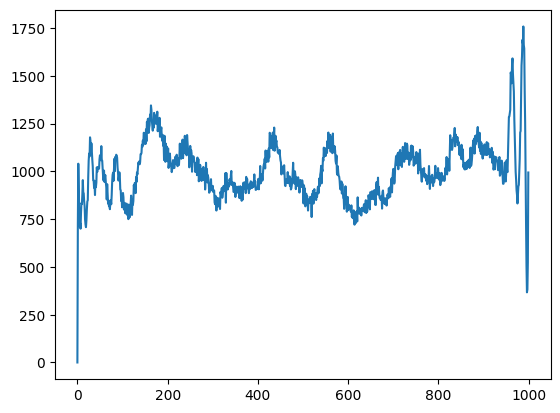

**Проверка гипотезы о нормальности**

<BarContainer object of 3 artists>

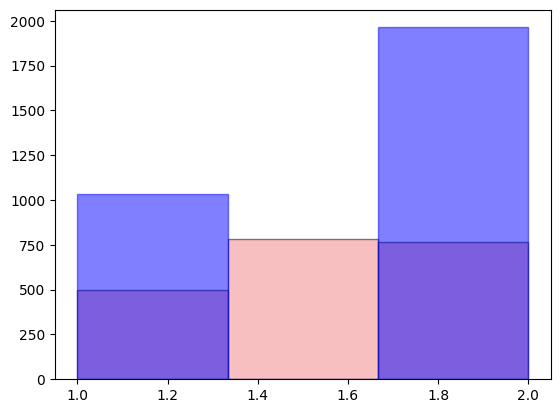

In [70]:
num_bins = n
#num_bins = n//4#math.ceil(math.log2(len(all_degrees)) + 1)

hist_values, bin_edges = np.histogram(all_degrees, bins=num_bins)

# Вывод диапазонов бинов
bin_mid = []
lg = bin_edges[1] - bin_edges[0]
for i in range(len(bin_edges) - 1):
    bin_mid.append((bin_edges[i+1] + bin_edges[i])/2)
    #print(f"Бин {i+1}: [{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]")

mu, sigma = np.mean(all_degrees), np.std(all_degrees)

# Вычисление ожидаемых частот для нормального распределения
expected_freqs = []
for i in range(len(bin_edges) - 1):
    p = norm.cdf(bin_edges[i+1], mu, sigma) - norm.cdf(bin_edges[i], mu, sigma)
    expected_freqs.append(p * len(all_degrees))

plt.bar(bin_mid, expected_freqs, width=lg, edgecolor="black", alpha=0.5, color='lightcoral', label="Ожидаемые частоты")
plt.bar(bin_mid, hist_values, width=lg, edgecolor="blue", alpha=0.5, color='blue', label="Ожидаемые частоты")

#plt.hist(all_degrees, bins=num_bins, edgecolor='black', alpha=0.5)

In [615]:
from scipy.stats import chisquare

# Применение хи-квадрат теста
chi_stat, p_value = chisquare(expected_freqs)

# Вывод результатов
print(f"Хи-квадрат статистика: {chi_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результата
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Отклоняем гипотезу о нормальном распределении степеней вершин.")
else:
    print("Не можем отвергнуть гипотезу о нормальности.")


Хи-квадрат статистика: 2741.2041
P-значение: 0.0000
Отклоняем гипотезу о нормальном распределении степеней вершин.


**Проверка гипотезы о распределении пуассона**

<BarContainer object of 10 artists>

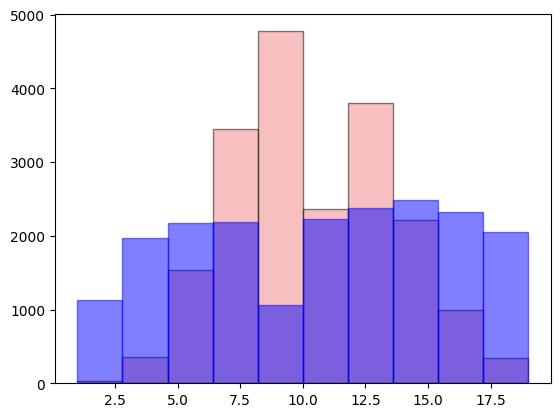

In [618]:
lambda_poisson = np.mean(all_degrees)

expected_freqs_poisson = []
for i in range(len(bin_edges) - 1):
    # Число событий в пределах интервала (bin)
    lower, upper = bin_edges[i], bin_edges[i + 1]
    expected_prob = poisson.cdf(upper, lambda_poisson) - poisson.cdf(lower, lambda_poisson)
    expected_freqs_poisson.append(expected_prob * len(all_degrees))

plt.bar(bin_mid, expected_freqs_poisson, width=lg, edgecolor="black", alpha=0.5, color='lightcoral', label="Ожидаемые частоты")
plt.bar(bin_mid, hist_values, width=lg, edgecolor="blue", alpha=0.5, color='blue', label="Ожидаемые частоты")